In [1]:
import sys
!{sys.executable} -m pip install pydicom -q


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip3.9 install --upgrade pip


In [5]:
import os

ix = os.getcwd().index('umich-mads-capstone-project')
ROOT_PATH = os.path.join(os.getcwd()[:ix], 'umich-mads-capstone-project')

data_path = os.path.join(ROOT_PATH, 'data/rsna')
annotations_file = os.path.join(data_path, 'rsna-targets.csv')
img_path = os.path.join(data_path, 'images')
viz_path = os.path.join(ROOT_PATH, 'figures')

In [8]:
import pandas as pd


label_df = pd.read_csv(annotations_file)
pneum_df = label_df[label_df['target']==1]
display(pneum_df.head())

patient_ids = pneum_df['patient_id'].unique().tolist()
num_patients = len(patient_ids)

print(num_patients)

record_dict = pneum_df.to_dict(orient='index')

,index,patient_id,x,y,width,height,target,split
4,17266,ae00e0cf-f575-44ce-8188-a611b464eb38,83.0,312.0,307.0,693.0,1,train
13,6748,52816546-4463-4a7f-a120-7d492a86a524,562.0,221.0,263.0,252.0,1,train
14,11665,7c8b9b44-5d6c-4e18-a42a-8a57e4273651,664.0,365.0,170.0,225.0,1,train
17,9350,690bbb39-1b67-4af0-94eb-7d1209e1ecef,188.0,455.0,219.0,341.0,1,train
21,13867,905fcc4a-7a63-4326-9e55-2e8a9ecf1d9c,202.0,498.0,323.0,357.0,1,train


6012


In [9]:
import pydicom as dicom
from PIL import Image
import matplotlib.pyplot as plt

def read_img(p_id):
    img_file = os.path.join(img_path, p_id + '.dcm')
    dcm_img = dicom.dcmread(img_file)
    img_arr = dcm_img.pixel_array
    return img_arr

def display_img(img_arr):
    plt.imshow(img_arr, cmap=plt.cm.bone)
    return None

def color_img(img, color):
    img = img.convert('RGBA')
    # Split into 3 channels
    r, g, b, a = img.split()
    if color == 'red':
        g = g.point(lambda x: 0)
        b = b.point(lambda x: 0)
    elif color == 'green':
        r = r.point(lambda x: 0)
        b = b.point(lambda x: 0)
    elif color == 'blue':
        r = r.point(lambda x: 0)
        g = g.point(lambda x: 0)
    else:
        print('Not an option')
    img = Image.merge('RGBA', (r, g, b, a))
    return img

def black_transparent(img):
    img = img.convert("RGBA")
    datas = img.getdata()

    newData = []
    for item in datas:
        if item[0] < 20 and item[1] < 20 and item[2] < 20:
            newData.append((0, 0, 0, 0))
        else:
            newData.append(item)
    img.putdata(newData)     
    return img


def max_ratio(img):
    hi = img.max()
    return hi / 254

def torch_img(img):
    img = img.astype(np.uint8)
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    return img

def avg_img(accum_img, num):
    img = np.copy(accum_img)
    img = img / num_patients
    img = torch_img(img)
    return img

def scale_img(accum_img):
    img = np.copy(accum_img)
    ratio = max_ratio(img)
    img = img / ratio
    img = torch_img(img)
    return img

def log_img(accum_img):
    img = np.copy(accum_img)
    img = np.log(img)
    ratio = max_ratio(img)
    img = img / ratio
    img = torch_img(img)
    return img

def power_img(accum_img, power):
    img = np.copy(accum_img)
    ratio = max_ratio(img)
    img = img / ratio
    img = img**power
    ratio = max_ratio(img)
    img = img / ratio
    img = torch_img(img)
    return img

def cutoff_img(accum_img, cutoff):
    img = np.copy(accum_img)
    ratio = max_ratio(img)
    img = img / ratio
    img[img >= cutoff] = 255
    img = torch_img(img)
    return img

In [10]:
#This is for creating BB distribution
import numpy as np
from datetime import datetime
import torch
import torchvision

accum_bb = np.zeros((1024,1024))

for idx, (k, v) in enumerate(record_dict.items()):

    x_min = int(v['x'])
    x_max = int(v['x'] + v['width'])
    y_min = int(v['y'])
    y_max = int(v['y'] + v['height'])
    accum_bb[y_min:y_max,x_min:x_max] += 255

    #if idx % 500 == 0:
        #print(f'idx: {idx}, percent: {(idx + 1)/len(patient_ids)} time: {datetime.now()}')

ModuleNotFoundError: No module named 'torch'

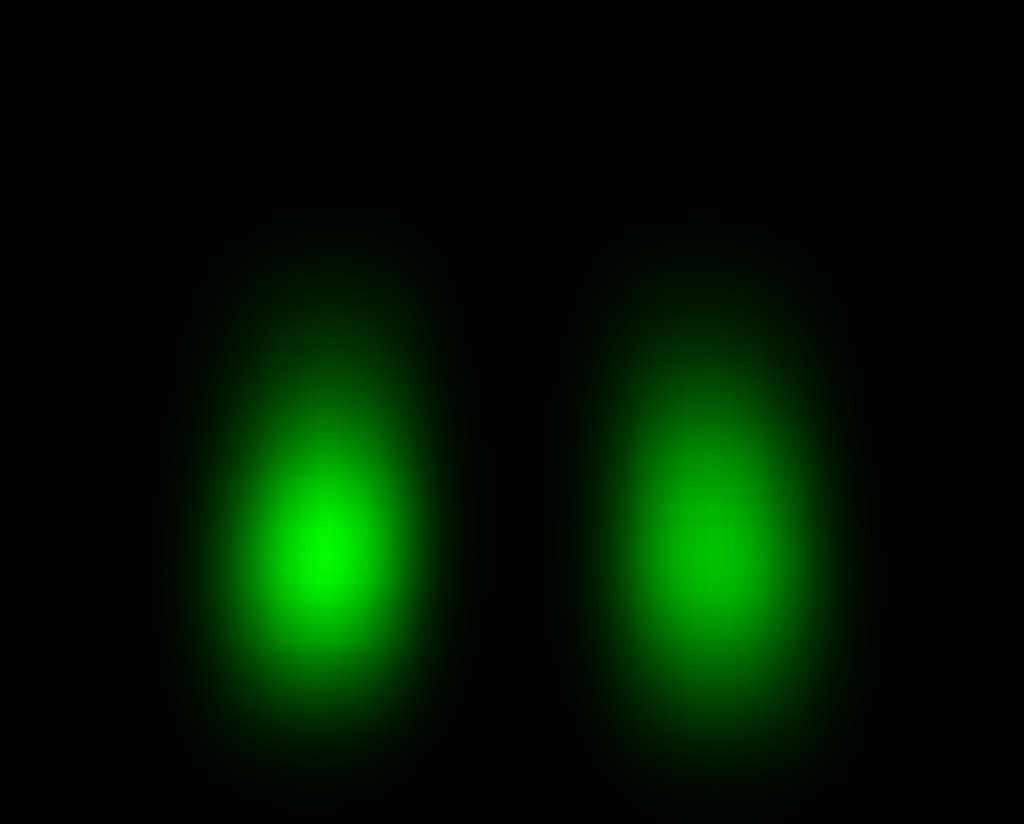

In [57]:
accum_bb = accum_bb[:-200,:]
img = power_img(accum_bb, 3)
bb = torchvision.transforms.ToPILImage()(img)
bb = color_img(bb, 'green')
bb

In [8]:
import pandas as pd
import numpy as np
from datetime import datetime

accum_chest = np.zeros((1024,1024))

for idx, p_id in enumerate(patient_ids):

    img_arr = read_img(p_id)
    accum_chest += img_arr
    
    #if idx % 500 == 0:
        #print(f'idx: {idx}, percent: {(idx + 1)/len(patient_ids)} time: {datetime.now()}')

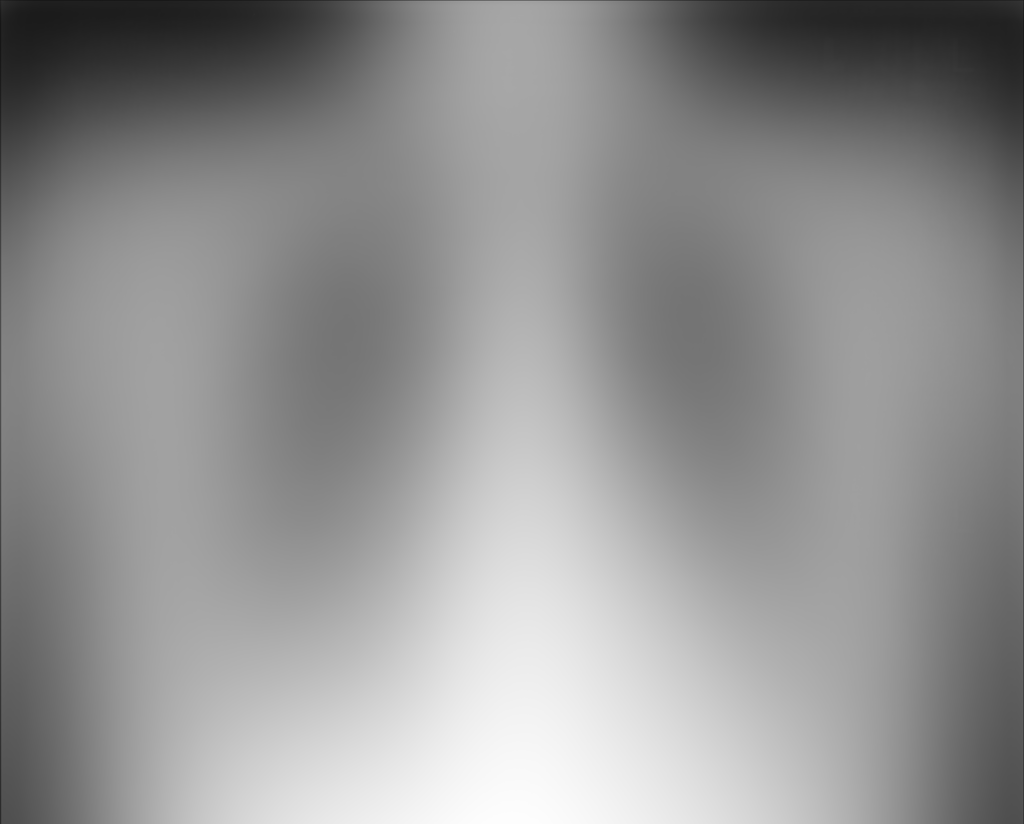

In [58]:
accum_chest = accum_chest[:-200,:]
img = power_img(accum_chest, 1)
chest = torchvision.transforms.ToPILImage()(img)
chest = chest.convert("RGBA")
chest

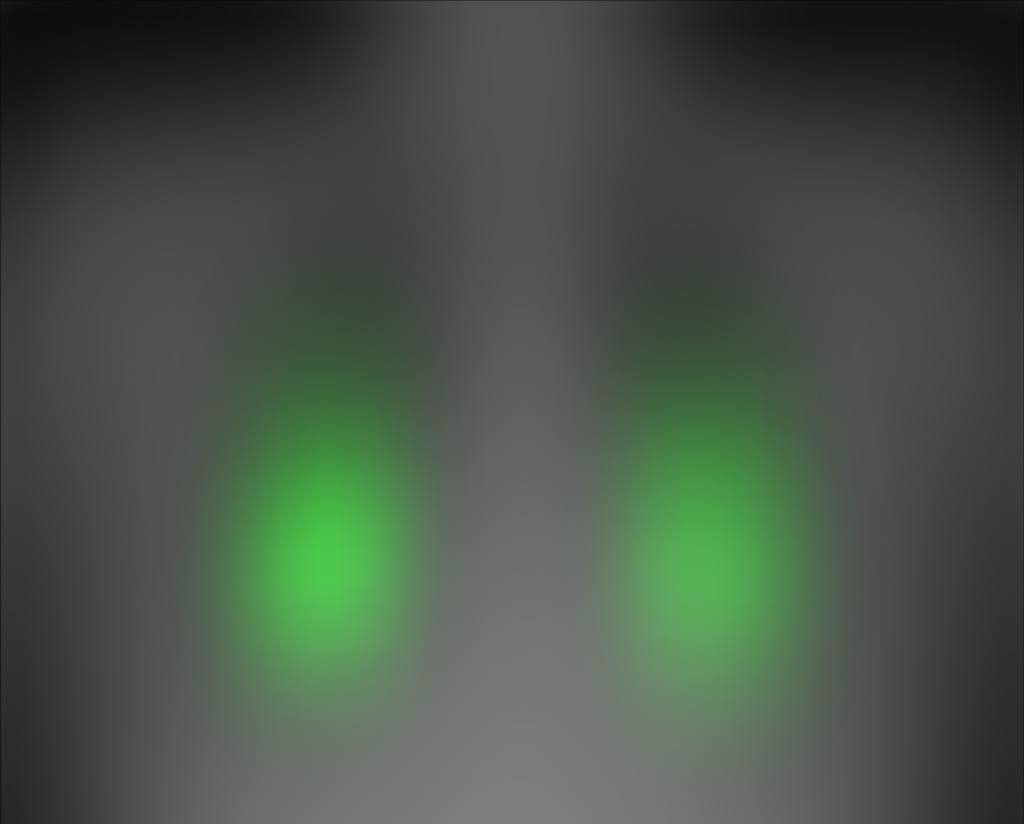

In [59]:
blended = Image.blend(chest, bb, 0.5)
blended

In [63]:
blended.save('visualizations/pneumo_heatmap.png')